<h1>Cluster District in Bangkok</h1>

<h2>A. Introduction</h2>

<h3>A.1. Description & Disscusion of the Background</h3>

<p>
In my hometown, Bangkok is the most visited city in the world, with comforts of megamalls, modern spaces, golden temples and shrines. Follow your nose to Bangkok’s countless street markets stuffed with spicy, sour, sweet, salty flavors, and hop on a boat to reach their floating markets.
</p>
<p>
However, Bangkok is very high-density population and very high traffic jams, with approximately 22 million international visitors. There are 10.7 million people live and population density of 5,294 people per square kilometer, divided into 50 administrative districts.</p>
<p>
If, I want to buy a new house or condo in Bangkok, it is advantageous for me to cluster each district in Bangkok for decision what location is best to buy.
</p>

<h3>A.2. Data Description</h3>

<ul>
    <li>I used Forsquare API to get the venues of each district in Bangkok.</li>    
    <li>I scrape common districts in Bangkok data from wikipedia.</li>    
    <li>I use my owned data about area in each district in Bangkok and calculate density population.</li>    
</ul>

<h1>B. Methodology</h1>

<h3>Import & Set Credential</h3>

In [61]:
import requests  

import pandas as pd 
from pandas.io.json import json_normalize

import numpy as np

from geopy.geocoders import Nominatim 
import geocoder 

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [62]:
CLIENT_ID = 'IRNDM0FF5HHW4I3AACXII3TW5ZOUJOUNK0QHJLFFSJ5ITPZE' # your Foursquare ID
CLIENT_SECRET = 'THW2UZ4OV0ISDLZW4V4OT5C0UWQQK10LZTJQ1QJKFTZ2KUZJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IRNDM0FF5HHW4I3AACXII3TW5ZOUJOUNK0QHJLFFSJ5ITPZE
CLIENT_SECRET:THW2UZ4OV0ISDLZW4V4OT5C0UWQQK10LZTJQ1QJKFTZ2KUZJ


<h3>Get Bangkok Coordination</h3>

In [64]:
address = 'Bangkok'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Bangkok are 13.7544238, 100.4930399.


<h3>Get Districts Data</h3>

In [65]:
bangkok_disticts_url = 'https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok'
r = requests.get(bangkok_disticts_url)

df_list = pd.read_html(r.text)
df_districts = df_list[0]
df_districts.head()

,District(Khet),MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444
3,Bang Khen,5,10220,บางเขน,189539,2,13.873889,100.596389
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,3,13.693333,100.502500


In [66]:
df_districts = df_districts.rename(columns={"District(Khet)": "District", "Post-code": "Postcode", "Popu-lation": "Population", "No. ofSubdis-trictsKhwaeng": "No. of Subdistricts"})
df_districts.drop(['MapNr', 'No. of Subdistricts'], axis=1, inplace=True)
df_districts.head()

,District,Postcode,Thai,Population,Latitude,Longitude
0,Bang Bon,10150,บางบอน,105161,13.659200,100.399100
1,Bang Kapi,10240,บางกะปิ,148465,13.765833,100.647778
2,Bang Khae,10160,บางแค,191781,13.696111,100.409444
3,Bang Khen,10220,บางเขน,189539,13.873889,100.596389
4,Bang Kho Laem,10120,บางคอแหลม,94956,13.693333,100.502500


In [67]:
map_bangkok_district = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, district in zip(df_districts['Latitude'], df_districts['Longitude'], df_districts['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bangkok_district)  
    
map_bangkok_district

<h3>Area Size Data & Calculate Population Density</h3>

In [68]:
df_district_area_size = pd.read_csv('bkk_district_area_size.csv')
df_district_area_size.head()

,District,area(km2)
0,Sai Mai,44.615
1,Bang Khae,44.456
2,Bang Khen,42.123
3,Khlong Sam Wa,110.686
4,Bang Khun Thian,120.687


In [69]:
df_districts = pd.merge(df_districts, df_district_area_size, on='District')

In [70]:
df_districts["Population Density"] = (df_districts['Population'] / df_districts['area(km2)'])
df_districts = df_districts.round({'Population Density': 2})

In [71]:
df_districts.head()

,District,Postcode,Thai,Population,Latitude,Longitude,area(km2),Population Density
0,Bang Bon,10150,บางบอน,105161,13.659200,100.399100,34.745,3026.65
1,Bang Kapi,10240,บางกะปิ,148465,13.765833,100.647778,28.523,5205.10
2,Bang Khae,10160,บางแค,191781,13.696111,100.409444,44.456,4313.95
3,Bang Khen,10220,บางเขน,189539,13.873889,100.596389,42.123,4499.66
4,Bang Kho Laem,10120,บางคอแหลม,94956,13.693333,100.502500,10.921,8694.81


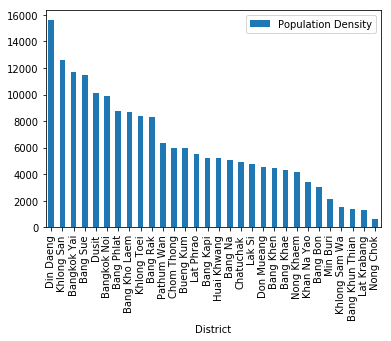

In [72]:
df_districts.head(30).sort_values(by='Population Density', ascending=False).plot(kind='bar', x='District', y='Population Density', rot=0)
plt.xticks(rotation=90)
plt.show()

<h3>Get Venues Each Districts</h3>

In [73]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [74]:
df_districts_venues = getNearbyVenues(names=df_districts['District'], 
                    latitudes=df_districts['Latitude'], 
                    longitudes=df_districts['Longitude'])

In [75]:
df_districts_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bang Bon,13.6592,100.3991,ขาหมูบางหว้า,13.657136,100.395230,Thai Restaurant
1,Bang Bon,13.6592,100.3991,Irashaimase Japanese Restaurant,13.658358,100.401403,Japanese Restaurant
2,Bang Bon,13.6592,100.3991,Lotus Express (โลตัส เอ็กซ์เพรส),13.657839,100.397243,Convenience Store
3,Bang Bon,13.6592,100.3991,The Rich Plaza,13.658626,100.397684,Shopping Plaza
4,Bang Bon,13.6592,100.3991,บ้านพลูหลวง,13.658532,100.398442,Thai Restaurant


In [76]:
df_districts_venues.groupby(['Venue Category'])['Venue Category'].count().sort_values(ascending=False)

Venue Category
Noodle House         127
Convenience Store     77
Thai Restaurant       71
Coffee Shop           66
Asian Restaurant      46
                    ... 
Dive Shop              1
Organic Grocery        1
Neighborhood           1
Music Venue            1
Women's Store          1
Name: Venue Category, Length: 154, dtype: int64

In [77]:
districts_venues_group = df_districts_venues.groupby(['District'])['Venue Category'].count().sort_values(ascending=False)
districts_venues_group.head()

District
Phaya Thai     88
Pathum Wan     80
Khlong San     52
Khan Na Yao    47
Ratchathewi    42
Name: Venue Category, dtype: int64

In [78]:
array = []

for k in districts_venues_group.keys():
    array.append({'Distict': k, 'Venue Count': districts_venues_group[k]})
df_districts_venues_group = pd.DataFrame(array)

df_districts_venues_group.head()

,Distict,Venue Count
0,Phaya Thai,88
1,Pathum Wan,80
2,Khlong San,52
3,Khan Na Yao,47
4,Ratchathewi,42


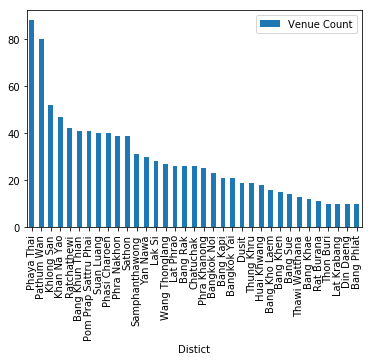

In [79]:
df_districts_venues_group.head(35).plot(kind='bar', x='Distict', y='Venue Count', rot=0)
plt.xticks(rotation=90)
plt.show()

<h3>Ranking Venues Each Districts</h3>

In [80]:
# one hot encoding
df_districts_venues_onehot = pd.get_dummies(df_districts_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
df_districts_venues_onehot['District'] = df_districts_venues['District'] 

# move district column to the first column
list_column = df_districts_venues_onehot.columns.tolist()
number_column = int(list_column.index('District'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
df_districts_venues_onehot = df_districts_venues_onehot[list_column]

df_districts_venues_onehot.head()

,District,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Badminton Court,Bakery,Bar,...,Tour Provider,Toy / Game Store,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
districts_venues_grouped = df_districts_venues_onehot.groupby('District').mean().reset_index()
districts_venues_grouped.head()

,District,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Badminton Court,Bakery,Bar,...,Tour Provider,Toy / Game Store,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,Bang Bon,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,Bang Kapi,0.0,0.0,0.047619,0.0,0.0,0.047619,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,Bang Khae,0.0,0.0,0.000000,0.0,0.0,0.083333,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.083333,0.0
3,Bang Khen,0.0,0.0,0.133333,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.066667,0.0,0.0,0.0,0.133333,0.0,0.000000,0.0
4,Bang Kho Laem,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.062500,0.0,0.000000,0.0


In [82]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [83]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['District'] = districts_venues_grouped['District']

for ind in np.arange(districts_venues_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(districts_venues_grouped.iloc[ind, :], num_top_venues)

districts_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,Thai Restaurant,Japanese Restaurant,Convenience Store,Shopping Mall,Shopping Plaza,Ramen Restaurant,Recording Studio,Pub,Pool,Recreation Center
1,Bang Kapi,Noodle House,Convenience Store,Bus Station,Flea Market,Coffee Shop,Steakhouse,Neighborhood,Ramen Restaurant,Museum,Som Tum Restaurant
2,Bang Khae,Convenience Store,Shopping Mall,Noodle House,Fast Food Restaurant,Coffee Shop,Pet Store,BBQ Joint,Wings Joint,Recreation Center,Recording Studio
3,Bang Khen,Asian Restaurant,Vietnamese Restaurant,Noodle House,Convenience Store,Bus Stop,Coffee Shop,Som Tum Restaurant,Garden Center,Garden,Train Station
4,Bang Kho Laem,Noodle House,Chinese Restaurant,Coffee Shop,Thai Restaurant,Shopping Mall,Vietnamese Restaurant,Fast Food Restaurant,Gym,Hotpot Restaurant,Supermarket


<h3>Cluster of Districts</h3>

In [84]:
# set number of clusters
kclusters = 3

districts_venues_grouped_clustering = districts_venues_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(districts_venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0,
       0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1, 1,
       0, 1, 0, 0, 0])

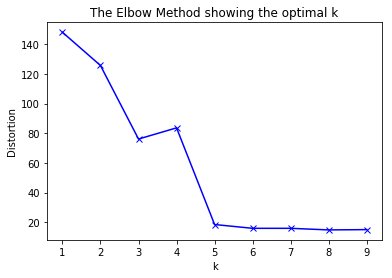

In [85]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(districts_venues_grouped_clustering)
    distortions.append(sum(np.min(cdist(districts_venues_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / districts_venues_grouped_clustering.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [86]:
bangkok_merged = df_districts

# add clustering labels
bangkok_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bangkok_merged = bangkok_merged.join(districts_venues_sorted.set_index('District'), on='District')

bangkok_merged.head() 

,District,Postcode,Thai,Population,Latitude,Longitude,area(km2),Population Density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,10150,บางบอน,105161,13.659200,100.399100,34.745,3026.65,2,Thai Restaurant,Japanese Restaurant,Convenience Store,Shopping Mall,Shopping Plaza,Ramen Restaurant,Recording Studio,Pub,Pool,Recreation Center
1,Bang Kapi,10240,บางกะปิ,148465,13.765833,100.647778,28.523,5205.10,1,Noodle House,Convenience Store,Bus Station,Flea Market,Coffee Shop,Steakhouse,Neighborhood,Ramen Restaurant,Museum,Som Tum Restaurant
2,Bang Khae,10160,บางแค,191781,13.696111,100.409444,44.456,4313.95,0,Convenience Store,Shopping Mall,Noodle House,Fast Food Restaurant,Coffee Shop,Pet Store,BBQ Joint,Wings Joint,Recreation Center,Recording Studio
3,Bang Khen,10220,บางเขน,189539,13.873889,100.596389,42.123,4499.66,0,Asian Restaurant,Vietnamese Restaurant,Noodle House,Convenience Store,Bus Stop,Coffee Shop,Som Tum Restaurant,Garden Center,Garden,Train Station
4,Bang Kho Laem,10120,บางคอแหลม,94956,13.693333,100.502500,10.921,8694.81,0,Noodle House,Chinese Restaurant,Coffee Shop,Thai Restaurant,Shopping Mall,Vietnamese Restaurant,Fast Food Restaurant,Gym,Hotpot Restaurant,Supermarket


<h3>1st Most Common Venue Each Cluster</h3>

In [87]:
count_venue = bangkok_merged
count_venue = count_venue.drop(['District', 'Postcode', 'Thai', 'Population', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,American Restaurant,Asian Restaurant,Bar,Café,Coffee Shop,Convenience Store,Intersection,Japanese Restaurant,Noodle House,Thai Restaurant
0,1,3,1,1,5,10,1,3,2,2
1,0,1,0,0,0,0,0,0,14,0
2,0,0,0,0,0,0,0,0,0,5


Text(0, 0.5, 'Clusters')

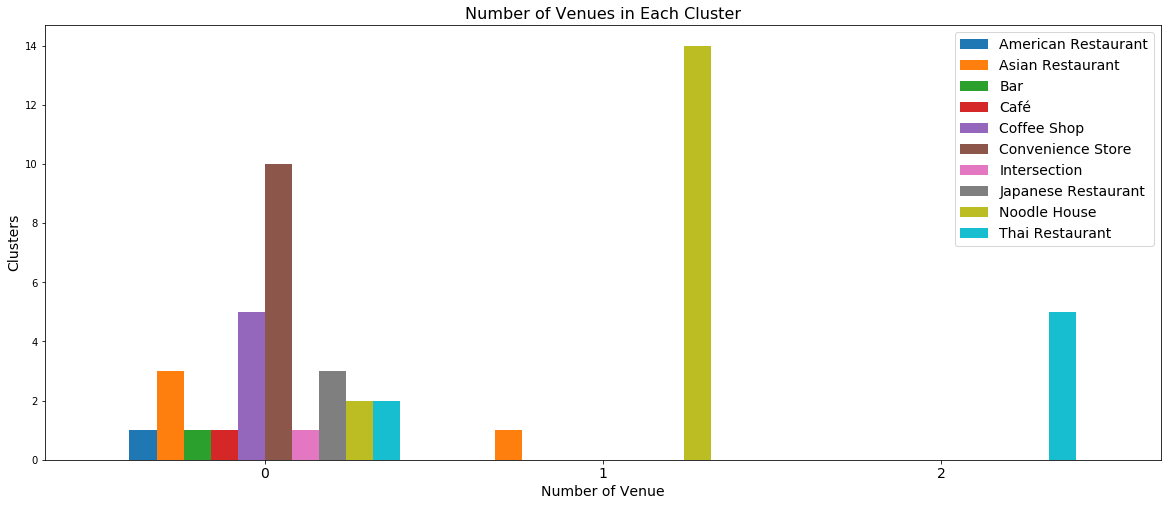

In [88]:
frame = cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)

In [89]:
Cluster_labels = {'Clusters': [0,1,2], 'Labels': ["Multiple Social Venues","Noodle House Venues","Thai Restaurant"]}
Cluster_labels = pd.DataFrame(data=Cluster_labels)
Cluster_labels

,Clusters,Labels
0,0,Multiple Social Venues
1,1,Noodle House Venues
2,2,Thai Restaurant


In [90]:
data_process = df_districts.sort_values(by='Population Density', ascending=False).reset_index(drop=True)
data_process = data_process.drop(['Latitude', 'Longitude', 'Postcode', 'Thai', 'area(km2)', 'Population'], axis=1)

data_process.head()

,District,Population Density,Cluster Labels
0,Pom Prap Sattru Phai,26414.29,0
1,Samphanthawong,19387.01,0
2,Din Daeng,15587.74,0
3,Thon Buri,13999.30,1
4,Khlong San,12633.61,0


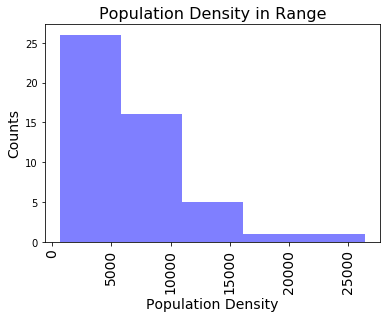

In [91]:
num_bins = 5
n, bins, patches = plt.hist(data_process['Population Density'], num_bins, facecolor='blue', alpha=0.5)
plt.title("Population Density in Range",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel('Population Density', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

In [92]:
level = []
for i in range(0,len(data_process)):
    if (data_process['Population Density'][i] < 5000):
        level.append("Low Level Population Density")
    elif (data_process['Population Density'][i] >= 5000 and data_process['Population Density'][i] < 10000):
        level.append("Mid-1 Level Population Density")
    elif (data_process['Population Density'][i] >= 10000 and data_process['Population Density'][i] < 15000):
        level.append("Mid-2 Level Population Density")
    elif (data_process['Population Density'][i] >= 15000 and data_process['Population Density'][i] < 20000):
        level.append("High-1 Level Population Density")
    else:
        level.append("High-2 Level Population Density")   

data_process['Level_labels'] = level
data_process.head(5)

,District,Population Density,Cluster Labels,Level_labels
0,Pom Prap Sattru Phai,26414.29,0,High-2 Level Population Density
1,Samphanthawong,19387.01,0,High-1 Level Population Density
2,Din Daeng,15587.74,0,High-1 Level Population Density
3,Thon Buri,13999.30,1,Mid-2 Level Population Density
4,Khlong San,12633.61,0,Mid-2 Level Population Density


In [93]:
top3 = df_districts_venues.groupby(['District','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['District','Counts'],ascending=False).groupby('District').head(3).reset_index(drop=True)

top3['Join'] = top3['Counts'].map(str) + " " + top3['Venue Category']
top3 = top3.groupby(['District'])['Join'].apply(", ".join).reset_index()

top3.head()

,District,Join
0,Bang Bon,"2 Thai Restaurant, 1 Convenience Store, 1 Japa..."
1,Bang Kapi,"4 Noodle House, 2 Convenience Store, 1 Asian R..."
2,Bang Khae,"3 Convenience Store, 2 Noodle House, 2 Shoppin..."
3,Bang Khen,"2 Asian Restaurant, 2 Convenience Store, 2 Noo..."
4,Bang Kho Laem,"3 Noodle House, 2 Chinese Restaurant, 2 Coffee..."


<h1>C. Results</h1>

<h2>C.1. Main table with results</h2>

In [94]:
result = pd.merge(bangkok_merged, 
                    top3[['District', 'Join']],
                    left_on = 'District',
                    right_on = 'District',
                    how = 'left')
result= pd.merge(result, 
                    Cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')
result = pd.merge(result, 
                    data_process[['District', 'Level_labels']],
                    left_on = 'District',
                    right_on = 'District',
                    how = 'left')

result = result.drop(['Clusters'], axis=1)
result.head(3)

,District,Postcode,Thai,Population,Latitude,Longitude,area(km2),Population Density,Cluster Labels,1st Most Common Venue,...,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Join,Labels,Level_labels
0,Bang Bon,10150,บางบอน,105161,13.659200,100.399100,34.745,3026.65,2,Thai Restaurant,...,Shopping Mall,Shopping Plaza,Ramen Restaurant,Recording Studio,Pub,Pool,Recreation Center,"2 Thai Restaurant, 1 Convenience Store, 1 Japa...",Thai Restaurant,Low Level Population Density
1,Bang Kapi,10240,บางกะปิ,148465,13.765833,100.647778,28.523,5205.10,1,Noodle House,...,Flea Market,Coffee Shop,Steakhouse,Neighborhood,Ramen Restaurant,Museum,Som Tum Restaurant,"4 Noodle House, 2 Convenience Store, 1 Asian R...",Noodle House Venues,Mid-1 Level Population Density
2,Bang Khae,10160,บางแค,191781,13.696111,100.409444,44.456,4313.95,0,Convenience Store,...,Fast Food Restaurant,Coffee Shop,Pet Store,BBQ Joint,Wings Joint,Recreation Center,Recording Studio,"3 Convenience Store, 2 Noodle House, 2 Shoppin...",Multiple Social Venues,Low Level Population Density


<h2>C.2. Map with results</h2>

In [95]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, join, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['District'], result['Labels'], result['Join'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(join), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color= rainbow[cluster_number-1],
        popup=label,
        fill_color = rainbow[cluster_number-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

<h1>D. Discussion</h1>

<p>
Bangkok is a very high population density in a narrow area. As there are many different approaches that can be used for clustering and classification studies.
</p>
<p>
I used the K-Means algorithm for this clustering study. Although, there are many factors if you are on decision what location you should buy or lend house or condo in Bangkok, for example, your work location, budget, etc. But this model can be one of very useful for support decision.
</p>
<p>
However, this model has not enough data for precise clustering. Now, it’s only an approximate cluster. But this model is a good basis for improvement and adding more features to more precision in the future.
</p>

<h1>F. Conclusion</h1>

<p>
In this study, I develop a clustering model for understanding the cluster of each district in Bangkok according to population density and social place density. Although, there are many factors if you are on decision what location you should buy or lend house or condo in Bangkok, for example, your work location, budget, etc. But this model can be one of very useful for support decision.
</p>

<h1>G. References:</h1>

<ul>
    <li><a href="https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok">Bangkok District Wikipedia</a></li>
    <li><a href="https://developer.foursquare.com/">Forsquare API</a></li>
    <li><a href="http://www.bangkok.go.th/upload/user/00000130/Logo/statistic/stat%202015(ENG).pdf">Bangkok Statistics</a></li>
<ul>